# 利用DWT处理图像

In [ ]:
import cv2
import numpy as np
import pywt
#高精度小数运算
from decimal import Decimal as dm
#设置console效果
np.set_printoptions(threshold=np.inf)

# 定义实体类，实体类存储符号和其对应的概率和编码区间，这是利用python面向对象编程~
class SymbolAndProbability:
    symbol = 'x'
    probability = 0.0
    left = 0.0
    right = 0.0

    # 构造函数~
    def __init__(self, symbol, probability, left, right):
        self.symbol = symbol
        self.probability = probability
        self.left = left
        self.right = right
def imTodwt(sru):
    img = cv2.imread(sru)
    img2 = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY).astype(np.float32)
    #对原图片进行缩小，减少运算
    img2=cv2.resize(img2,(0,0),fx=0.5,fy=0.5)
    # img2 = cv2.cvtColor(img,cv2.COLOR_BGR2YCR_CB).astype(np.float32)
    img_dc = img2 - 128

    coeffs = pywt.dwt2(img_dc, 'haar')
    cA, (cH, cV, cD) = coeffs

    #小波变换系数
    AH = np.concatenate([cA, cH], axis=1)
    VD = np.concatenate([cV, cD], axis=1)
    img = np.concatenate([AH, VD], axis=0)


    #量化
    '''numpy.floor(x)：返回输入的底部(标量 x 的底部是最大的整数 i)。
    
    '''

    qfy = np.sign(img)*np.floor(np.abs(img))
    row,column=qfy.shape
    #将qfy值作为索引遍历，所以先变为正数，记录index 0-511
    qfy_count=qfy+255
    #编码，求出每个值出现的概率
    #num即得到了每个数字出现的次数
    num = np.zeros(512)
    for i in range(0,row):
        for j in range(0,column):
            num[qfy_count[i][j].astype(np.int16)] = 1+num[qfy_count[i][j].astype(np.int16)]
    sum_num = row*column
    #pos得到每种数字的概率值
    pos = num / sum_num
    #将符号和对应的概率存入列表
    list_index=list()
    list_pro=list()
    for index in range(512):
        if num[index]!=0:
            list_index.append((index-255))
    for pro in pos :
        if pro!=0:
            list_pro.append(pro)
    list_index=list_index
    #dict_pro=dict(zip(list_index,list_pro))
    #计算熵值，获得最佳编码方案
    Hx=0
    for i in range(512):
        if pos[i]!=0:
         Hx=Hx+np.log2(pos[i])*pos[i]
    Hx=-Hx
    print('图像的熵值是：',Hx)

    return list_index,list_pro,qfy,Hx

#二进制与十进制的转换
def deTobin(dec:dm,dec_flag:int)->str:
    bin_str='0.'
    for i in range(dec_flag):
        dec=dec*2
        bin=int(dec)
        bin_str=bin_str+str(bin)
        dec=dm(dec-int(dec))

    return bin_str


def binTode(bin_str:str)->dm:
    dec=dm(0.0)
    for i in range(2,len(bin_str)):
        dec=dec+dm(pow(2,1-i))*dm(bin_str[i])
    return dec
#计算要用多少位
def bin_num(dec):
    count=0
    if dec==0:return -1
    else:
        while(dec<1):
            dec=2*dec
            count+=1
        return count

# 算术编码~
def AM_code(rgb_list:list,arr,x_index=0,start_temp:dm=0.0,end_temp:dm=1.0,flag_eye='yes')->str:
    gap=dm(end_temp-start_temp)
    #flag记录是否找到
    flag=0
    for y_index in range(1,len(arr)):
        #找到每一个字符的位置
        if arr[y_index].symbol==rgb_list[x_index]:
            #print(arr[y_index].symbol)
            start=dm(arr[y_index].left)
            end=dm(arr[y_index].right)
            flag=1
    if flag==0:
        print(rgb_list[x_index],'is not in the array,ignore')
        #使得区间保持上一次的结果
        start=dm(0.0)
        end=dm(1.0)

    # 规划区间，不断计算缩小
    temp=dm(start_temp)
    start_temp=dm(dm(start_temp)+gap*start)
    end_temp=dm(dm(temp)+gap*end)
    #遍历完，返回最后区间中值小数的bit码
    if x_index==(len(rgb_list)-1):
        dec=(start_temp+end_temp)/2
        if (end_temp-start_temp)==0:
            print('-----------超过最大能计算小数长度-------------')
            exit(0)
        #计算多少位二进制能够区别区间
        dec_flag=bin_num((end_temp-start_temp))
        encode = deTobin(dec, dec_flag)
        if flag_eye=='yes':
             print('编码对象:',rgb_list,'二进制编码:',encode,'编码长度:',dec_flag)
        return encode
    x_index=x_index+1
    return AM_code(rgb_list,arr,x_index,start_temp,end_temp)

# 算术解码
def AM_decode(encode:str,arr,group_step)->list():
    #记录元素个数
    length=group_step
    #将二进制转化为十进制小数
    dec_decode=binTode(encode)
    #列表返回解码元素
    decode_list=[]
    #避免数学bug，count用于计数
    count=0
    for x_index in range(length):
        for y_index in range(1,len(arr)):
            if arr[y_index].left<= dec_decode<arr[y_index].right:
                if count == length: break
                decode_list.append(arr[y_index].symbol)
                dec_decode=(dec_decode-arr[y_index].left)/(arr[y_index].right-arr[y_index].left)
                count+=1
    return decode_list

# 打印输入内容
def class_print_all(arr):
    print("\n>>>符号，对应概率和编码区间为：")
    for x_index in range(1, len(arr)):
        print(arr[x_index].symbol,':',  arr[x_index].probability, '[', arr[x_index].left, ",", arr[x_index].right,']')


# 输入概率和符号
def symbol_probability_input(symbol:list,probability:list):
    sum_p=0
    for x_index in range(0, len(probability)):
        sum_p += dm(probability[x_index])
    if abs(sum_p - 1) > 1e-4:
        print("error! 概率不具有完备性！")
        exit(0)
    if len(symbol) != len(probability):
        print("error! 输入符号数目与概率数目不匹配")
        exit(0)
    arr = []
    init = SymbolAndProbability(symbol='zero', probability=0, left=0, right=0)
    # arr第一个元素（下标为0）存放有关初始化的操作
    arr.append(init)
    for x_index in range(1, len(probability) + 1):
        # 当前的符号，准备存入实体类
        syb = symbol[x_index - 1]
        # 当前的概率，准备存入实体类
        pb = probability[x_index - 1]
        # 当前的区间左端点为前一区间的右端点，准备存入实体类
        left = arr[x_index - 1].right
        # 实例化类
        new_element = SymbolAndProbability(symbol=syb, probability=pb, left=left, right=dm(left) + dm(pb))
        arr.append(new_element)
    return arr
def AM_grouping_process(qfy:np.ndarray,arr,step):
    row, column = qfy.shape
    qfy_list = qfy.flatten()
    #装入编码
    code_list=[]
    '''分块处理，以避免overflow的情况'''
    group_step=step
    last_group_length=len(qfy_list)%group_step
    group_num=int(len(qfy_list)/group_step)
    group_matric=np.array(qfy_list[0:group_num*group_step]).reshape(group_num,group_step)


    print('---------------------开始编码----------------------')
    flag_eye = input('是否显示具体编码过程，yes/no')
    #分块传入，进行编码
    for i in range(group_num):
        code=AM_code(list(group_matric[i]),arr,flag_eye=flag_eye)
        code_list.append(code)
    #刚好分组时不用处理余数部分
    if last_group_length!=0:
        code_last=AM_code(qfy_list[-1-last_group_length:-1],arr)
        code_list.append(code_last)
    print('---------------------编码完成----------------------')
    #将编码所得的code_list解码
    print('---------------------开始解码----------------------')
    #列表用于存储解码元素
    qfy_decode_list=[]
    bit_length=0
    for i in range(len(code_list)-1):
        #计算平均码字
        bit_length+=int(len(code_list[i])-2)
        #分块解码
        code_group=AM_decode(code_list[i],arr,group_step)
        qfy_decode_list.extend(code_group)
    #处理最后一个码字，最后一个码字长度不固定
    if last_group_length==0:
        group_step=group_step
    else:
        group_step=last_group_length
    # 计算平均码字
    bit_length += int(len(code_list[-1]) - 2)
    # 分块解码
    code_group = AM_decode(code_list[-1], arr, group_step)
    qfy_decode_list.extend(code_group)

    #将元素列表转回矩阵
    qfy_decode=np.array(qfy_decode_list).reshape(row,column)
    print('---------------------解码完成----------------------')
    equal_length=float(bit_length) / (row * column)
    print('平均码长:',equal_length,'相对于uint8类型的jpg压缩率为{:.2%}'.format(equal_length/8.0))
    return qfy_decode


if __name__ == '__main__':
    print('------------------开始JPEG2000编码---------------------')
    #获取图片
    sru='1.jpf'
    #小波变换
    sym,pro,qfy,Hx=imTodwt(sru)
    #将概率符号区间存入结构体
    array_sy_pb = symbol_probability_input(sym,pro)
    # 打印具体信息
    str_flag=input('是否显示符号对应概率区间yes/no')
    if str_flag=='yes':
       class_print_all(array_sy_pb)
    # 获得算术编码结果
    row,column=qfy.shape
    qfy_list=qfy.flatten()
    #解码编码
    #考虑到溢出的情况，进行分组编码
    try:
       step=int(input('请输入分块的步长，以调节压缩率，建议小于6'))
    except:
        print('请输入整数而不是字符')
    #try:
    AM_grouping_process(qfy,array_sy_pb,step)
    #except:
        #print('步长太大，数据溢出')


In [1]:
from PIL import Image
import PIL
import matplotlib.pyplot as plt
import pywt
import numpy as np

In [6]:
# 图像类
class DNAImage:
    def __init__(self, image:Image):
        self.image = image
        self.imageP = None
        self.color_palette = None    # 调色板矩阵
        self.array = None            # 基于调色板的原始图像矩阵 每像素8bit的彩色图  维度(x, y, 1)
        self.shape = None
        
        self.R_array = None 
        self.G_array = None
        self.B_array = None
        self.RGB_array = None          # RGB通道图像矩阵，利用调色板和原始图像矩阵还原 维度（x, y, 3)
        
        self.DWT_array = None
        self.info_init()
        
    def info_init(self):
        self.color_palette = get_color_palette(self.image)
        self.imageP = self.image.convert("P")
        self.array = np.array(self.imageP)
        self.shape = self.array.shape
        
        self.RGB_array = np.zeros(shape=(self.shape[0], self.shape[1], 3))
        for row in range(self.shape[0]):
            for colum in range(self.shape[1]):
                for cIndex in range(3):
                    self.RGB_array[row, colum, cIndex] = self.color_palette[self.array[row, colum]][cIndex]
        print(self.RGB_array)
        
    def DWT(self, level):
        c = pywt.wavedec2(self.array, 'db2', mode="periodization", level=level)
        self.DWT_array = c
        return self
    
    def show(self):
        plt.imshow(self.RGB_array/255)
        
    def showDWT(self):
        shape = self.DWT_array[0].shape
        print(shape)
        
        RGB_array = np.zeros(shape=(shape[0], shape[1], 3))
        for row in range(shape[0]):
            for colum in range(shape[1]):
                for cIndex in range(3):
                    RGB_array[row, colum, cIndex] = self.color_palette[int(np.around(self.DWT_array[0])[row, colum])][cIndex]
        plt.imshow(RGB_array/255)
        

# 调色板转换

In [ ]:
# 获取图片的调色板
def get_color_palette(image: Image):
    plt.imshow(image)
    img_data = image.convert("P")
    img_arr = np.array(img_data)
    return np.array(img_data.getpalette()).reshape(256, 3)

[[[238. 241. 248.]
  [  1. 195. 218.]
  [  1. 195. 218.]
  ...
  [  1. 195. 218.]
  [  1. 195. 218.]
  [  1. 195. 218.]]

 [[238. 241. 248.]
  [  1. 195. 218.]
  [  1. 195. 218.]
  ...
  [  1. 195. 218.]
  [  1. 195. 218.]
  [  1. 195. 218.]]

 [[238. 241. 248.]
  [  1. 195. 218.]
  [  1. 195. 218.]
  ...
  [  1. 195. 218.]
  [  1. 195. 218.]
  [  1. 195. 218.]]

 ...

 [[238. 241. 248.]
  [  1. 195. 218.]
  [  1. 195. 218.]
  ...
  [  1. 195. 218.]
  [  1. 195. 218.]
  [  1. 195. 218.]]

 [[238. 241. 248.]
  [  1. 195. 218.]
  [  1. 195. 218.]
  ...
  [  1. 195. 218.]
  [  1. 195. 218.]
  [  1. 195. 218.]]

 [[238. 241. 248.]
  [  1. 195. 218.]
  [  1. 195. 218.]
  ...
  [  1. 195. 218.]
  [  1. 195. 218.]
  [  1. 195. 218.]]]
(3508, 2480)


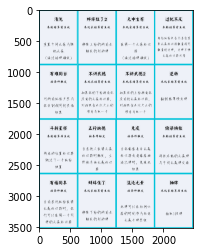

In [9]:
#get_color_palette(Image.open("3.png"))
dna = DNAImage(Image.open("3.png"))
print(dna.shape)

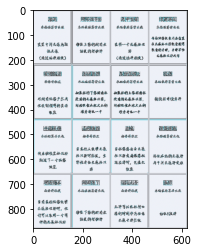

In [14]:
a = np.around(dna.DWT(2).DWT_array[0])
shape = a.shape

b = np.zeros(shape=(shape[0], shape[1], 3))
for i in range(shape[0]):
    for j in range(shape[1]):
        for k in range(3):
            b[i, j, k] = dna.color_palette[int(a[i, j])][k]
plt.imshow(b/255)

In [66]:
a = np.round(dna.DWT(2).DWT_array[0])


In [50]:
test = np.random.randint(0, 255, size=[10,10])
test -= int(np.around(test.mean()))
print(test)


pywt.wavedec2(test, 'db2', mode="periodization", level=1)

[[-122  -83  113  -38   47  118 -106  -93  100  107]
 [  91    2  -86   68  124  -20   -9   46  -18    5]
 [-106  -66  120  107   -3  102  -10   58  -17   88]
 [  21   41  -58  -89  121    7   98   41  -25  -72]
 [-124 -127  125  108  -71  -39   32  -33   85  -54]
 [-118  -82    6   36   22    5  124  -80   43   65]
 [-117   13   22  -47 -118   47 -101  -49  -35 -109]
 [  34  -65  -78   53  -56   60   19  -70   10   72]
 [ -70   90 -102  -48   53 -120  -14  106  -28  -54]
 [  60   67   18  -30  100   33  -47   35   30  -93]]


[array([[ -31.16362529,   18.62165187,  111.42779473,  -72.42058052,
           65.24310797],
        [   1.99607072,   18.69351184,  138.8575225 ,   68.00176039,
           25.69774016],
        [-146.09021766,   22.64294919,   23.26434209,   65.82931002,
           53.94653779],
        [-147.81561228,    0.74991367,  -73.52771766,   -5.44799914,
          -45.2077676 ],
        [   0.33206006,  -86.12450517,    2.36907449,  -17.78252713,
            6.90720496]]),
 (array([[ 128.74093908, -117.42257676,   51.6574408 ,  -13.71064403,
           -45.06642928],
         [  89.30936459, -102.34350259,   15.45383832,   74.8664971 ,
           -55.38509064],
         [  39.49343014,  -47.61971883,   63.09904273,   91.78508139,
            42.12227309],
         [ 118.80734522,  -38.9115196 ,   12.54014984,   48.35080312,
           -12.97249506],
         [  59.29405598,   27.33437847,   41.8165156 ,   21.2455759 ,
           -30.48475459]]),
  array([[ -52.24205512, -105.16905598,  115.1